<a href="https://colab.research.google.com/github/changyong93/Natural-language-processing-with-chat-bot/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC_%EC%9E%85%EB%AC%B8(13_6_NLP%EB%A5%BC_%EC%9C%84%ED%95%9C_%EC%8B%A0%EA%B2%BD%EB%A7%9D(CNN)_%EC%96%91%EB%B0%A9%ED%96%A5_LSTM%EA%B3%BC_CRF(Bidirectional_LSTM_%2B_CRF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 양방향 LSTM과 CRF(Bidirectional LSTM + CRF)
---
- Bi-LSTM+CRF, F1_score
- 모델 생성 전까지의 과정은 13-5와 동일

## 실습 전 참고사항
---
- CRF layer는 현재 텐서플로우 1.14.0버전과 케라스 2.2.4에서 가장 원활하게 동작
- 버전 맞추기

In [1]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0

#CRF 사용을 위한 keras_contrib 설치
!pip install git+https://www.github.com/keras-team/keras-contrib.git

     |████████████████████████████████| 109.3MB 94kB/s 
     |████████████████████████████████| 491kB 50.3MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 3.2MB 39.0MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 317kB 8.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 377.1MB 46kB/s 
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-1_kblc9o
  Running command git clone -q h

## 개체명 인식 데이터에 대한 이해와 전처리

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data = pd.read_csv("./gdrive/MyDrive/Colab Notebooks/ner_dataset.csv", encoding = 'latin1')
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
data.shape

(1048575, 4)

In [6]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


In [7]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [8]:
len(data), data["Sentence #"].nunique(), data.Word.nunique(), data.Tag.nunique()

(1048575, 47959, 35178, 17)

In [9]:
#테그 카운트
data.groupby("Tag").size().reset_index(name = "count")

,Tag,count
0,B-art,402
1,B-eve,308
2,B-geo,37644
3,B-gpe,15870
4,B-nat,201
5,B-org,20143
6,B-per,16990
7,B-tim,20333
8,I-art,297
9,I-eve,253


In [10]:
data = data.fillna(method = 'ffill')
data[:20]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [11]:
data.isnull().any()

Sentence #    False
Word          False
POS           False
Tag           False
dtype: bool

In [12]:
data["Word"] = data.Word.str.lower()
print("전체 문자 소문자로 변환 후 단어 개수: ", data.Word.nunique())

전체 문자 소문자로 변환 후 단어 개수:  31817


In [13]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [14]:
#단어와 개체명 묶기
func = lambda temp: [(w,t) for w,t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences = [t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 수: ", len(tagged_sentences))

전체 샘플 수:  47959


In [15]:
print(tagged_sentences[0])

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [16]:
sentences, ner_tags = [],[]

for tagged_sentence in tagged_sentences:
  sentence, tag_info = zip(*tagged_sentence)
  sentences.append(list(sentence))
  ner_tags.append(list(tag_info))

In [17]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


Text(0, 0.5, 'number of samples')

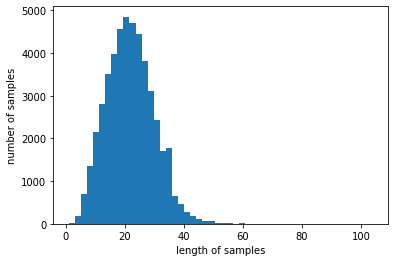

In [18]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

In [19]:
src_tokenizer = Tokenizer(oov_token= "OOV")
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer(lower = False) #태깅 정보의 대문자 유지
tar_tokenizer.fit_on_texts(ner_tags)

In [20]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [21]:
src_tokenizer.word_index["OOV"]

1

In [22]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [23]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word

ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = "PAD"

In [24]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [25]:
max_len = 70
# 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [27]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [28]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


## F1-Score

In [29]:
!pip install seqeval

     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=2b542fd43903a95bb742636de4679e758897fd9ce4a622e9feeb5331b3e5e7ff
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [30]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

Using TensorFlow backend.


In [31]:
class F1score(Callback):
    def __init__(self, value = 0.0, use_char = True):
      super(F1score, self).__init__()  #uper(파생클래스, self)로 기반 클래스의 메서드 호출 =>  파생 클래스와 self를 넣어서 현재 클래스가 어떤 클래스인지 명확하게 표시
      self.value = value
      self.use_char = use_char

    def sequences_to_tags(self, sequences): #예측값을 index_to_ner을 사용하여 태깅 정보로 변환
      result = []
      for sequence in sequences:
        tag = []
        for pred in sequence:
          pred_index = np.argmax(pred)
          tag.append(index_to_ner[pred_index].replace("PAD","O"))
        result.append(tag)
      return result

    # 에포크가 끝날 때마다 실행되는 함수
    # 부모 클래스(Callback)에서 상속 후 매서드 변경
    def on_epoch_end(self, epoch, logs = {}):

      #char Embedding을 사용하는 경우
      if self.use_char:
        X_test = self.validation_data[0]
        X_char_test = self.validation_data[1]
        y_test = self.validation_data[2]
        y_predicted = self.model.predict([X_test, X_char_test])

      else:
        X_test = self.validation_data[0]
        y_test = self.validation_data[1]
        y_predicted = self.model.predict([X_test])

      pred_tags = self.sequences_to_tags(y_predicted)
      test_tags = self.sequences_to_tags(y_test)

      score = f1_score(pred_tags, test_tags)
      print(' - f1: {:04.2f}'.format(score * 100))
      print(classification_report(test_tags, pred_tags))

      # F1-score가 지금까지 중 가장 높은 경우
      if score > self.value:
        print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
        self.model.save('best_model.h5')
        self.value = score
      else:
        print('f1_score did not improve from %f'%(self.value))


## BiLSTM을 이용한 개체명인식기

In [35]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.models import load_model
# from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
# from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, TimeDistributed, Embedding
# from keras.optimizers import Adam
from keras.models import load_model
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
#viterbi 알고리즘 : 관측된 사건들의 순서를 야기한 가장 가능성 높은 은닉 상태 순서(비터비 경로)를 찾기 위한 동적 알고리즘

In [49]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 64, input_length=max_len, mask_zero = True))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(TimeDistributed(Dense(units = 50, activation = 'relu')))
crf = CRF(units = tag_size)
model.add(crf)
model.compile(optimizer='adam', loss = crf.loss_function, metrics = [crf.accuracy])


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [51]:
history = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 10, validation_split=0.1, verbose=1, callbacks=[F1score(use_char=False)])

Train on 34530 samples, validate on 3837 samples
Epoch 1/10
34530/34530 [==============================] - 403s 12ms/step - loss: 8.3118 - crf_viterbi_accuracy: 0.9107 - val_loss: 8.1211 - val_crf_viterbi_accuracy: 0.9515
 - f1: 76.82


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        37
         eve       0.00      0.00      0.00        30
         geo       0.83      0.82      0.83      3087
         gpe       0.93      0.93      0.93      1146
         nat       0.00      0.00      0.00        16
         org       0.76      0.41      0.53      1691
         per       0.65      0.73      0.69      1310
         tim       0.87      0.78      0.83      1672

   micro avg       0.81      0.73      0.77      8989
   macro avg       0.51      0.46      0.47      8989
weighted avg       0.80      0.73      0.76      8989

f1_score improved from 0.000000 to 0.768211, saving model to best_model.h5
Epoch 2/10
34530/34530 [==============================] - 403s 12ms/step - loss: 8.0919 - crf_viterbi_accuracy: 0.9626 - val_loss: 8.0881 - val_crf_viterbi_accuracy: 0.9593
 - f1: 80.40
              precision    recall  f1-score   support

         art       0.00      0.00

In [53]:
bilstm_crf_model = load_model('best_model.h5',custom_objects={'CRF' : crf,
                                                              'crf_loss' : crf_loss,
                                                              'crf_viterbi_accuracy' : crf_viterbi_accuracy})

In [54]:
i=13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = bilstm_crf_model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


## 실제 모델에 대해서 f1 score 구하기

In [55]:
f1score = F1score()

y_predicted = bilstm_crf_model.predict([X_test])
pred_tags = f1score.sequences_to_tags(y_predicted)
test_tags = f1score.sequences_to_tags(y_test)

In [56]:
print(classification_report(test_tags, pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.64      0.27      0.38        52
         geo       0.84      0.85      0.85      7620
         gpe       0.98      0.93      0.95      3145
         nat       1.00      0.05      0.10        37
         org       0.70      0.58      0.64      4033
         per       0.79      0.75      0.77      3545
         tim       0.86      0.85      0.86      4067

   micro avg       0.83      0.79      0.81     22562
   macro avg       0.73      0.54      0.57     22562
weighted avg       0.83      0.79      0.81     22562



In [57]:
f1_score(test_tags,pred_tags)

0.8126291879613856